In [ ]:
%pylab inline

%config InlineBackend.figure_format = 'retina'
import pandas as pd
from glob import glob
import os,sys
from numpy import linspace
from itertools import combinations
import json
jlo = lambda s: json.load(open(s,'r'))

import gln_v8 as gln
import functions as fc
from scipy.optimize import curve_fit

In [ ]:
## run simulations ##

segments = 8
samples = 400

temperatures = linspace(1e-2, 4, 40)

for T in temperatures:
    os.system("""./run_temp_sims_segments.py "{'samples':%d, 'T':%f, 'segments':%d}" & """ %(samples, T, segments))

# analysis

In [3]:
def get_data(files):
    sims = glob(files)
    data = {}

    full_data = pd.DataFrame()
    first = True
    for s in sims:
        T = (s.strip('.csv').split('-T')[1].split('-')[0])
        p = pd.read_csv(s)
        data[T] = p
        p_temp = p.join(pd.DataFrame({'Temperature': [float(T)]*p.shape[0]}))
        full_data = full_data.append(p_temp)
    return data, full_data

In [4]:
def get_stats(data):
    stats = []
    metric = 'nGLN'
    for T in data:
        # get the temperature, mean and std of nGLN 
        y = data[T][metric]
        stats += [[float(T), y.mean(), y.std()]]

    stats = array(stats)
    stats = stats[argsort(stats[:,0])]
    return stats


In [9]:
full_data = {}
data = {}

pattern = '../sims/temperature/Temperature-Lattice-d3-segments8-N100-T*.csv'
segs = int(pattern.strip('.csv').split('segments')[1].split('-')[0])
data[segs], full_data[segs] = get_data(pattern)



In [10]:
stats = {s:get_stats(data[s]) for s in full_data}

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


Epsilon = 0.22, Shift = 0.44
(array([1.29189558, 0.2180348 , 0.44112776]), array([[ 0.01223511,  0.00524182, -0.00218413],
       [ 0.00524182,  0.00230479, -0.00099793],
       [-0.00218413, -0.00099793,  0.00051581]]))
Epsilon = 0.62, Shift = 0.48
(array([0.6247384 , 0.47779357]), array([[ 4.78669557e-05, -4.57294937e-05],
       [-4.57294937e-05,  4.86013357e-05]]))


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6]),
 <a list of 10 Text yticklabel objects>)

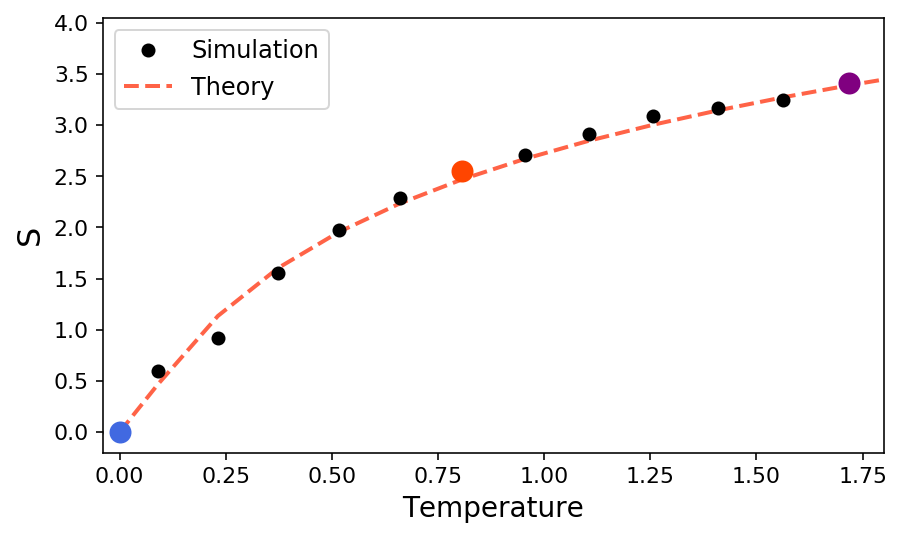

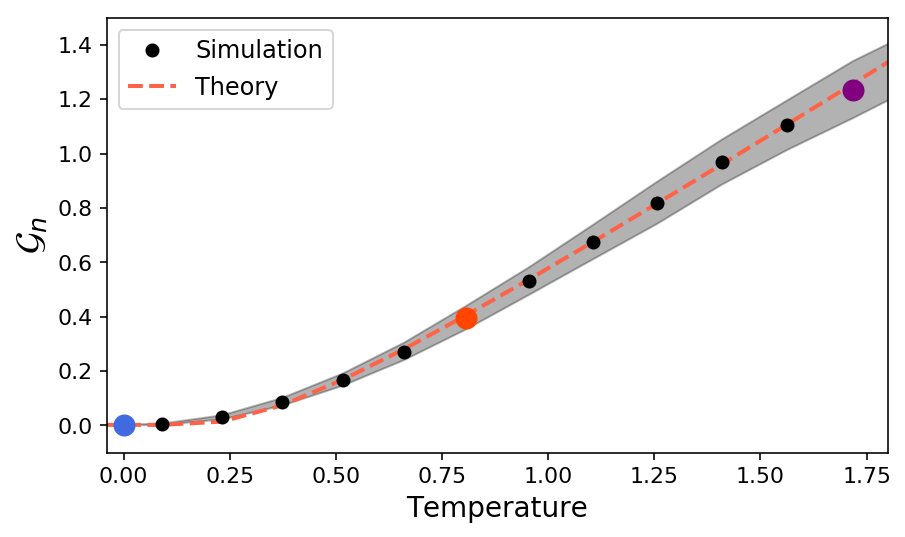

In [12]:
col = mpl.colors.TABLEAU_COLORS['tab:blue'], mpl.colors.TABLEAU_COLORS['tab:red']
color_fit = 'tomato' 
color_sim = 'black'

T_r = lambda t: (t-0.48)/0.62

ep = 1e-4

S = lambda t,N, eps, a:  N*(-log(1-exp(-eps/maximum(t-a, ep)))+ eps/maximum(t-a, ep)/(exp(eps/maximum(t-a, ep))-1))

T_delta = lambda delta: 1./ arcsinh(1/delta)

bin_size = 0.0068804 # [0.00689]:
ents = []

for k in data[8]:
    ngln8 = data[8][k]['nGLN']
    bins = 1 + int((ngln8.max()- ngln8.min()) / bin_size)

    count,bs = histogram(ngln8, bins)

    p = np.float32(count) / count.sum()
    rho = p/bin_size
#     entropy = -sum( rho * log( rho + 1e-8)*bin_size )
    entropy = -sum(p*log(p + 1e-8)) #+ log(bin_size)
    ents += [[T_delta(float(k)), entropy]]


ents = array(ents)
ents = ents[argsort(ents[:,0])]

T, entropies = ents.T

# T = T_delta(d) 
idx = where((T<1.7)*(T>0.5)) # where((T<1.5)*(T>0.1)) #where((d>0.1)*(d<1.1)) #where((T<10)*(T>4))
par = curve_fit(S, xdata= array([0.48]+T[idx].tolist()), ydata= array([0.0]+entropies[idx].tolist()),)#method = 'dogbox')

print( 'Epsilon = %.2g, Shift = %.2g' %tuple(par[0][1:]))
print par

figure(figsize= (7,4))
plot(T_r(ents.T[0]),ents.T[1], marker = 'o', ls = '',label='Simulation', color = color_sim,
     zorder = 100)
plot(0,0, marker = 'o', ls = '', color = 'royalblue', zorder = 100, markersize=10)
plot(T_r(ents.T[0][[8]]),ents.T[1][[8]], marker = 'o', ls = '', color = 'orangered', zorder = 100, markersize=10)
plot(T_r(ents.T[0][[14]]),ents.T[1][[14]], marker = 'o', ls = '', color = 'purple', zorder = 100, markersize=10)

plot(T_r(array([0.48]+T[idx].tolist())), [0]+S(T[idx],*par[0]).tolist(), marker = '',ls = '--', lw = 2,  color = color_fit , label = 'Theory')


legend(fontsize = 12)
ylabel('S', fontsize = 16)
xlabel('Temperature', fontsize = 14)

xlim(-0.04,1.8)
ylim(-0.2,4.05)


# tight_layout()

xticks(fontsize = 11)
yticks(fontsize = 11)

savefig('../figs/Entropy_vs_Temperature_highlighted_three_dots.svg',bbox_inches='tight')
savefig('../figs/Entropy_vs_Temperature_highlighted_three_dots.pdf',bbox_inches='tight')
savefig('../figs/Entropy_vs_Temperature_highlighted_three_dots.png', dpi = 300,bbox_inches='tight')

nGLN = lambda t,eps,a: 1/(exp(eps/maximum(t-a, 1e-1))-1)  # fitting epsilon

figure(figsize= (7,4))

i = 0

for s in [8]:
    d,y,yer = stats[s].T
    # fill_between(x, y+yer, y-yer, alpha = .3, color=col)
    
    T = T_delta(d)
    idx = where((d>0.2)*(d<1.3)) #where((T<10)*(T>4))
    par = curve_fit(nGLN, xdata= T[idx], ydata= (y)[idx],)
    print( 'Epsilon = %.2g, Shift = %.2g' %tuple(par[0]))
    print par
    
    fill_between(T_r(T), (y+2*yer), (y-2*yer), alpha = .3, color = color_sim)
    plot(T_r(T),y, lw = 0, marker = 'o', color = color_sim , 
         label = 'Simulation', zorder = 100)
    plot(0,0, marker = 'o', ls = '', color = 'royalblue', zorder = 100, markersize=10)
    plot(T_r(T[[8]]),y[[8]], marker = 'o', ls = '', color = 'orangered', zorder = 100, markersize=10)
    plot(T_r(T[[14]]),y[[14]], marker = 'o', ls = '', color = 'purple', zorder = 100, markersize=10)



    plot(T_r(T),nGLN(T, *par[0]), lw = 2,ls = '--', color = color_fit,#color= col[i], 
         label = 'Theory')
    i+=1
    
legend(fontsize = 12)
ylabel(r'$\mathcal{G}_n$', fontsize = 18)
xlabel('Temperature', fontsize = 14)
xlim(-0.04,1.8)
ylim(-.1,1.5)
# tight_layout()
xticks(fontsize = 11)
yticks(fontsize = 11)

savefig('../figs/nGLN_vs_Temperature_highlighted_three_dots.svg',bbox_inches='tight')
savefig('../figs/nGLN_vs_Temperature_highlighted_three_dots.pdf',bbox_inches='tight')
savefig('../figs/nGLN_vs_Temperature_highlighted_three_dots.png', dpi = 300,bbox_inches='tight')